In [2]:
import numpy as np
import jax
import jax.numpy as jnp
from jax.tree_util import tree_flatten, tree_unflatten, tree_structure
import jax_dataclasses as jdc
import chex
from functools import partial
import diffrax
from exciting_environments import core_env
from numba import njit
from scipy.io import loadmat
from scipy.interpolate import RegularGridInterpolator, griddata
from pathlib import Path


In [3]:
LUT_PATH=Path.cwd().parent /'exciting_environments'/'saturated_pmsm'

In [4]:
saturated_quants = ["L_dd", "L_dq",
                                "L_qd", "L_qq", "Psi_d", "Psi_q", ]
pmsm_lut = loadmat(LUT_PATH/'LUT_data.mat')
for q in saturated_quants:
    qmap = pmsm_lut[q]
    x, y = np.indices(qmap.shape)
    nan_mask = np.isnan(qmap)
    qmap[nan_mask] = griddata(
        (x[~nan_mask], y[~nan_mask]),  # points we know
        qmap[~nan_mask],    # values we know
        (x[nan_mask], y[nan_mask]),  # points to interpolate
        method='nearest')   # extrapolation can only do nearest
    pmsm_lut[q] = qmap

i_max = 250
n_grid_points_y, n_grid_points_x = pmsm_lut[saturated_quants[0]].shape
x, y = np.linspace(-i_max, 0, n_grid_points_x), \
    np.linspace(-i_max, i_max, n_grid_points_y)
interpolators = {q: RegularGridInterpolator((x, y), pmsm_lut[q][:, :].T,
                                                    method='linear', bounds_error=False,
                                                    fill_value=None)
                        for q in saturated_quants}


In [5]:
import matplotlib.pyplot as plt
from matplotlib import cm

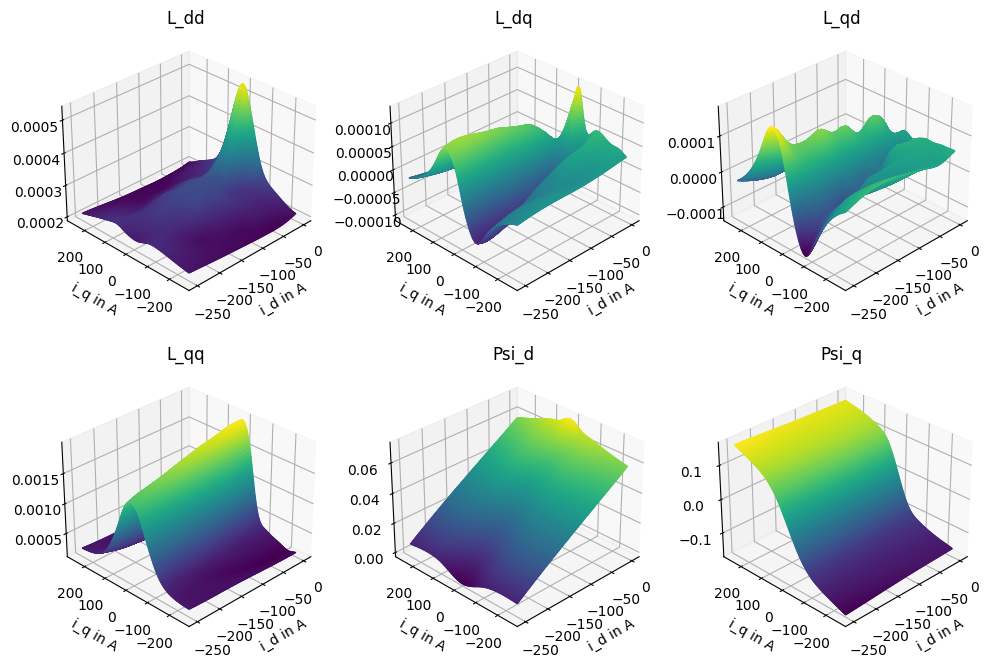

In [6]:
fig = plt.figure(figsize=(12,8))
xx = np.linspace(-250, 0, 101)
yy = np.linspace(-250, 250, 201)
X, Y = np.meshgrid(xx, yy, indexing='ij')
for  i,(name, interp) in  zip(range(6),interpolators.items()):
    Z = interp((X,Y))
    ax = fig.add_subplot(2, 3, i+1, projection='3d')
    norm = plt.Normalize(Z.min(), Z.max())
    colors = cm.viridis(norm(Z))
    rcount, ccount, _ = colors.shape
    surf = ax.plot_surface(X, Y, Z, rcount=rcount, ccount=ccount,
                       facecolors=colors, shade=False)
    surf.set_facecolor((0,0,0,0))
    ax.azim=225
    ax.set_xlabel("i_d in A")
    ax.set_ylabel("i_q in A")
    ax.set_title(name)

plt.show()

### JAX

In [7]:
saturated_quants = ["L_dd", "L_dq",
                                "L_qd", "L_qq", "Psi_d", "Psi_q", ]
pmsm_lut = loadmat(LUT_PATH/'LUT_data.mat')
for q in saturated_quants:
    qmap = pmsm_lut[q]
    x, y = jnp.indices(qmap.shape)
    nan_mask = jnp.isnan(qmap)
    qmap[nan_mask] = griddata(
        (x[~nan_mask], y[~nan_mask]),  # points we know
        qmap[~nan_mask],    # values we know
        (x[nan_mask], y[nan_mask]),  # points to interpolate
        method='nearest')   # extrapolation can only do nearest
    pmsm_lut[q] = qmap

i_max = 250
n_grid_points_y, n_grid_points_x = pmsm_lut[saturated_quants[0]].shape
x, y = jnp.linspace(-i_max, 0, n_grid_points_x), \
    jnp.linspace(-i_max, i_max, n_grid_points_y)
jax_interpolators = {q: jax.scipy.interpolate.RegularGridInterpolator((x, y), pmsm_lut[q][:, :].T,
                                                    method='linear', bounds_error=False,
                                                    fill_value=None)
                        for q in saturated_quants}


In [8]:
# fig = plt.figure(figsize=(12,8))
# xx = np.linspace(-250, 0, 101)
# yy = np.linspace(-250, 250, 201)
# X, Y = np.meshgrid(xx, yy, indexing='ij')
# for  i,(name, interp) in  zip(range(6),jax_interpolators.items()):
#     Z = interp((X,Y))
#     ax = fig.add_subplot(2, 3, i+1, projection='3d')
#     norm = plt.Normalize(Z.min(), Z.max())
#     colors = cm.viridis(norm(Z))
#     rcount, ccount, _ = colors.shape
#     surf = ax.plot_surface(X, Y, Z, rcount=rcount, ccount=ccount,
#                        facecolors=colors, shade=False)
#     surf.set_facecolor((0,0,0,0))
#     ax.azim=225
#     ax.set_xlabel("i_d in A")
#     ax.set_ylabel("i_q in A")
#     ax.set_title(name)

# plt.show()

In [9]:
pos=-np.random.rand(1000,2)*250

In [10]:
def compute(interp,pos,idx):
    return 10+(interp["L_dd"](pos[idx]))

def test_interpol(interp,pos):
    value=10
    for i in range(pos.shape[0]):
        value+=compute(interp,pos,i)
    return value

In [11]:
@jax.jit
def compute_jit(interp,pos,idx):
    return 10+(interp["L_dd"](pos[idx]))

def test_interpol_jit(interp,pos):
    value=10
    for i in range(pos.shape[0]):
        value+=compute_jit(interp,pos,i)
    return value

In [15]:
test_interpol(jax_interpolators,pos)

Array([10010.156], dtype=float32)

In [14]:
test_interpol_jit(jax_interpolators,pos)

Array([10010.156], dtype=float32)

In [26]:
jitted_tes=jax.jit(test_interpol)

In [27]:
jitted_tes(jax_interpolators,pos[:1])

[Array([0.00022889], dtype=float32)]

In [29]:
jitted_tes(jax_interpolators,pos)

[Array([0.00022889], dtype=float32),
 Array([0.00020821], dtype=float32),
 Array([0.00020877], dtype=float32),
 Array([0.00021763], dtype=float32),
 Array([0.00020156], dtype=float32),
 Array([0.00022598], dtype=float32),
 Array([0.00024125], dtype=float32),
 Array([0.00020071], dtype=float32),
 Array([0.00021047], dtype=float32),
 Array([0.00021465], dtype=float32),
 Array([0.00020205], dtype=float32),
 Array([0.00021306], dtype=float32),
 Array([0.00020469], dtype=float32),
 Array([0.00027257], dtype=float32),
 Array([0.0002523], dtype=float32),
 Array([0.00021466], dtype=float32),
 Array([0.00020008], dtype=float32),
 Array([0.00022361], dtype=float32),
 Array([0.00022118], dtype=float32),
 Array([0.00020104], dtype=float32),
 Array([0.00020912], dtype=float32),
 Array([0.00020527], dtype=float32),
 Array([0.00020766], dtype=float32),
 Array([0.00023571], dtype=float32),
 Array([0.00023922], dtype=float32),
 Array([0.00021096], dtype=float32),
 Array([0.0002424], dtype=float32),
 Ar